# Band Gap Prediction using *Ward 2016* Method

This notebook uses the method from [Ward 2016](https://www.nature.com/articles/npjcompumats201628) to predict band gap of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_file = "datasets/oqmd_groundstate.data"
delimiter = ' '
comp_col = "comp"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~300000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
        
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))

    return training_set

training_set = load_training_set(training_file, delimiter)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
training_set = training_set.replace("None", np.nan)
training_set = training_set.dropna()

## Create PyMatGen Composition objects

In [ ]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)

training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
1,Hf1,-9.923202,22.36760,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf)
3,Mo1,-10.419117,15.92040,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo)
4,Nb1,-9.800921,18.67330,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb)
5,Ni1,-5.552162,10.70220,0.611777266667,0.0,0.014457,0.01445706,True,(Ni)
6,Os1,-11.181135,14.28270,7.71e-05,0.0,0.044841,0.04484125,True,(Os)
8,Pm1,-4.741485,34.23060,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm)
9,Pr1,-4.768796,35.98410,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr)
11,Sm1,-4.711020,33.58290,0.0106331333333,0.0,0.003747,0.00374735916667,True,(Sm)
13,Tc1,-10.345199,14.47630,-0.00934373333333,0.0,0.015549,0.015548835,True,(Tc)
17,Ac1,-4.102718,44.87960,0.0010475,0.0,0.003286,0.00328580916667,True,(Ac)


## Compute descriptors using MatMiner
Here, we compute 145 composition based attributes as described in *Ward 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [ ]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.Stoichiometry().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.IonProperty().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

#%lprun -f calc_attributes calc_attributes()

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

(117454, 158)
CPU times: user 6min 3s, sys: 1.69 s, total: 6min 5s
Wall time: 6min 5s


## Predicting band gaps

In [ ]:
#Drop NaN values from training set

training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = training_set_use.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,0-norm,...,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons,Avg Ionic Char,Max Ionic Char,compound possible
1,Hf1,-9.923202,22.36760,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf),1.0,...,14.000000,0.000000,2.000000,0.111111,0.777778,0.000000,0.111111,0.000000,0.000000,1.0
3,Mo1,-10.419117,15.92040,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo),1.0,...,0.000000,0.000000,1.000000,0.833333,0.000000,0.000000,0.166667,0.000000,0.000000,1.0
4,Nb1,-9.800921,18.67330,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb),1.0,...,0.000000,0.000000,1.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
5,Ni1,-5.552162,10.70220,0.611777266667,0.0,0.014457,0.01445706,True,(Ni),1.0,...,0.000000,0.000000,2.000000,0.800000,0.000000,0.000000,0.200000,0.000000,0.000000,1.0
6,Os1,-11.181135,14.28270,7.71e-05,0.0,0.044841,0.04484125,True,(Os),1.0,...,14.000000,0.000000,2.000000,0.272727,0.636364,0.000000,0.090909,0.000000,0.000000,1.0
8,Pm1,-4.741485,34.23060,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm),1.0,...,5.000000,0.000000,2.000000,0.000000,0.714286,0.000000,0.285714,0.000000,0.000000,1.0
9,Pr1,-4.768796,35.98410,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr),1.0,...,3.000000,0.000000,2.000000,0.000000,0.600000,0.000000,0.400000,0.000000,0.000000,1.0
11,Sm1,-4.711020,33.58290,0.0106331333333,0.0,0.003747,0.00374735916667,True,(Sm),1.0,...,6.000000,0.000000,2.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,1.0
13,Tc1,-10.345199,14.47630,-0.00934373333333,0.0,0.015549,0.015548835,True,(Tc),1.0,...,0.000000,0.000000,2.000000,0.714286,0.000000,0.000000,0.285714,0.000000,0.000000,1.0
17,Ac1,-4.102718,44.87960,0.0010475,0.0,0.003286,0.00328580916667,True,(Ac),1.0,...,0.000000,0.000000,2.000000,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,1.0


In [ ]:
#Band gap data
bandgaps = np.array(training_set_use["bandgap"], dtype=float)
print bandgaps

#Band gap range data
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

[ 0.  0.  0. ...,  0.  0.  0.]


### Predict band gap range using classifiers

In [ ]:
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], bg_range)
prediction = model1.predict(training_set_use[attr_names])

In [ ]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,113259,4,5,2
1,80,1756,7,0
2,14,5,1488,3
3,4,2,5,820


In [ ]:
model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], bg_range)
prediction = model2.predict(training_set_use[attr_names])

In [ ]:
pd.crosstab(bg_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,0,1,2,3
actual,,,,
0,113270,0,0,0
1,0,1843,0,0
2,0,0,1510,0
3,0,0,0,831


In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
prediction = rf_model.predict(training_set_use[attr_names])

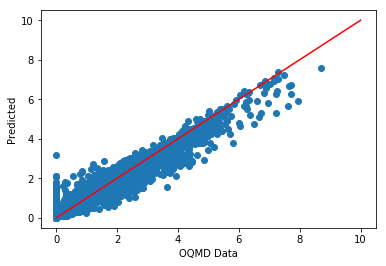

In [ ]:
plt.scatter(bandgaps, prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [ ]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.0560449502013
CPU times: user 10min 57s, sys: 1.19 s, total: 10min 58s
Wall time: 10min 59s


### Decision Tree Regressor

In [ ]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], bandgaps)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [ ]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

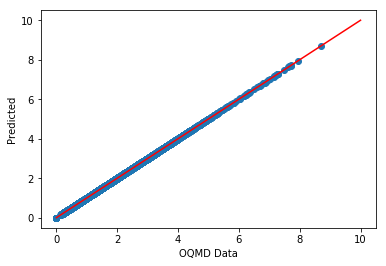

In [ ]:
plt.scatter(bandgaps, dt_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [ ]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.0600166032497
CPU times: user 1min 47s, sys: 712 ms, total: 1min 47s
Wall time: 1min 48s
